# Tutorial: Signal Processing and Machine Learning for EEG-based BCI

## Introduction

In this tutorial, we will review some common [signal processing](https://en.wikipedia.org/wiki/Signal_processing) and [machine learning](https://en.wikipedia.org/wiki/Machine_learning) techniques that have been used in [EEG](https://en.wikipedia.org/wiki/Electroencephalography)-based [brain-computer interface](https://en.wikipedia.org/wiki/Brain–computer_interface) (BCI) systems to translate brain signals into messages and commands.

Despite the fact that most of the techniques covered in this notebook can be used with **any** kind of neural time series data, we will **only** be covering **EEG** data.

<img src="http://epscicon.vidyaacademy.ac.in/wp-content/uploads/2017/12/eeg.jpg" width="500"/>

## Preliminaries

### Disclaimer

This notebook owes much of its content to the [MNE](https://martinos.org/mne/) and [PyRiemann]([PyRiemann](https://github.com/alexandrebarachant/pyRiemann)) packages.

Most of the examples were partially inspired by the well-documented and high-quality tutorials available in the official documentations (most of which, by the way, are also available as Jupyter notebooks).

To all the developers who have contributed to these modules:

<img src="https://media.giphy.com/media/WV9Xx9itqEIu8GQloO/giphy.gif" width="400"/>

### EEG 101

*So, what exactly is EEG?*

**E**lectro**E**ncephalo**G**raphy (EEG for short) is an [electrophysiology](https://en.wikipedia.org/wiki/Electrophysiology) technique used to study and visualize brain activity.

<figure>
   <div align="center">
       <img src="https://upload.wikimedia.org/wikipedia/commons/7/7e/1st-eeg.png"/ width="700">
       <figcaption>
           <em>The first human EEG recording obtained by <a href="https://en.wikipedia.org/wiki/Hans_Berger">Hans Berger</a> in 1924</em>
       </figcaption>
   </div>
</figure>

It is a **non-invasive** technique that uses electrodes placed directly on the scalp to measure the electrical fields generated by the joint activity of populations of neurons located in the outer layers of the brain.

<figure>
   <div align="center">
       <img src="https://www.researchgate.net/profile/Jose_Del_R_Millan/publication/41387051/figure/fig2/AS:655139811622922@1533208911622/EEG-principle-electrical-fields-generated-by-aligned-pyramidal-cells-Source-Bear-6.png" width="400"/>
       <figcaption>
           <em>EEG principle: electrical fields generated by aligned pyramidal cells</em>
       </figcaption>
   </div>
</figure>

As a rule-of-thumb, non-synchronous neural activity gives rise to **<span style="color:red">fast, low amplitude</span>** waves, while synchronized neural activity yields **<span style="color:green">slow, high amplitude</span>** waves.

| Type  | Frequency (Hz) | Location                                                               | 
| :---: | :-------: | ---------------------------------------------------------------------- |
| &#948; (delta) | `0.1 - 4` | frontally in adults, posteriorly in children; <br>high amplitude waves |
| &#952; (theta) | `4 - 8` | found in locations unrelated to the task |
| &#945; (alpha) | `8 - 13` | posterior regions of the brain on both sides; <br> higher in amplitude on the non-dominant side; <br> central sites (`C3`, `C4`) at rest |
| &#956; (mu)    | `8 - 13` | sensorimotor cortex |
| &#946; (beta)  | `>13 - 30` | both sides, symmetrical distribution; <br> most evident frontally; <br> low amplitude waves |
| &#947; (gamma) | `30 - 100` | somatosensory cortex |

### MNE

We will be using the [MNE](https://martinos.org/mne/) package extensively to analyze EEG data.

If you haven't done so already, please download the MNE module:

In [1]:
!pip install mne

Import it:

In [2]:
import mne

and (optionally) adjust the log level to make the output less verbose:

In [3]:
mne.set_log_level('WARNING')

#### Generic Modules

For most applications, it's usually a good idea to import some generic *stuff*

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

try:
    import PyQt5.QtCore
    %matplotlib qt
except ImportError:
    %matplotlib inline

## Data

### EEGBCI Dataset

MNE provides easy access to some public [datasets](https://mne.tools/stable/overview/datasets_index.html).

In this tutorial, we will use the [EEG Motor Movement/Imagery Dataset
](https://physionet.org/content/eegmmidb/1.0.0/) (EEGBCI) dataset which is available at PhysioNet. 

This dataset contains <span style="color:red">**64-channel EEG**</span> recordings from <span style="color:red">**109 subjects**</span> and <span style="color:red">**14 runs**</span> on each subject in [EDF+](https://www.edfplus.info) format.

The recordings were made using the [BCI2000](https://en.wikipedia.org/wiki/BCI2000) system.

**Experimental Runs:**

1. Baseline, eyes open
2. Baseline, eyes closed
3. Task 1 (open and close left or right fist)
4. Task 2 (imagine opening and closing left or right fist)
5. Task 3 (open and close both fists or both feet)
6. Task 4 (imagine opening and closing both fists or both feet)
7. Task 1
8. Task 2
9. Task 3
10. Task 4
11. Task 1
12. Task 2
13. Task 3
14. Task 4

Each annotation includes one of three codes (`T0`, `T1`, or `T2`):

* `T0` corresponds to rest
* `T1` corresponds to onset of motion (real or imagined) of
    * the left fist (in runs 3, 4, 7, 8, 11, and 12)
    * both fists (in runs 5, 6, 9, 10, 13, and 14)
* `T2` corresponds to onset of motion (real or imagined) of
    * the right fist (in runs 3, 4, 7, 8, 11, and 12)
    * both feet (in runs 5, 6, 9, 10, 13, and 14)

We will use the [`eegbci.load_data`](https://mne.tools/stable/generated/mne.datasets.eegbci.load_data.html) funcion to fetch the data for the EEGBCI dataset and return the paths to local copies of EEGBCI dataset files.

In [5]:
from mne.datasets import eegbci

# Select subjects
subjects = range(1, 2)

# Select runs
runs = [6, 10, 14]  # motor imagery (hands vs feet)

raw_fnames = []
for subject in subjects:
    raw_fnames += eegbci.load_data(subject, runs)

### Loading Data

MNE stores continuous data in objects of type [`Raw`](https://mne.tools/dev/generated/mne.io.Raw.html). 

In essence, the `Raw` data structure is just a 2D numpy array (`channels × samples`, `._data`) combined with an [`Info`](https://mne.tools/dev/generated/mne.Info.html) object (`.info`). 

Information about the channels contained in the `Raw` object is contained in the `Info` attribute which behaves pretty much like a *dictionary*.

We will use the [`mne.read_raw_edf`](https://mne.tools/dev/generated/mne.io.read_raw_edf.html) function to convert the EDF files into raw objects (`RawEDF`) and join all objects into a single continuous one with [`concatenate_raws`](https://mne.tools/stable/generated/mne.concatenate_raws.html) function. Please notice that [MNE supports most standard file formats](https://mne.tools/dev/overview/implementation.html#supported-data-formats).

**Note:** if you're not using too much data, it's usually a good idea to preload the data into memory for easy manipulation and faster indexing

In [6]:
from mne import concatenate_raws
from mne.io import read_raw_edf

# Load data
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])

# Clean up channel names
raw.rename_channels(lambda x: x.strip('.'))

# Data is stored as a numpy array
print(type(raw._data))

# Metadata for the recording is available as an info object
print(raw.info)

# Check sample rate
print('sample rate:', raw.info['sfreq'], 'Hz')

# Gives the size of the data matrix
print('channels x samples:', raw._data.shape)

<class 'numpy.ndarray'>
<Info | 7 non-empty values
 bads: []
 ch_names: Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
>
sample rate: 160.0 Hz
channels x samples: (64, 60000)


In MNE, the [typical EEG workflow](https://mne.tools/stable/overview/cookbook.html) always involves some kind of transformation on these `Raw`-type objects

<figure>
   <div align="center">
       <img src="https://mne.tools/stable/_images/flow_diagram.svg"/>
       <figcaption>
           <em>Workflow of the MNE software</em>
       </figcaption>
   </div>
</figure>

### Montage

In EEG parlance, **montage** means electrode placement.

In this notebook, we will use the `standard_1005` montage where electrodes are named and positioned according to the international **10-05 system** (343+3 locations).

In [7]:
from mne.channels import make_standard_montage

# Set channel names
eegbci.standardize(raw)
montage = make_standard_montage('standard_1005')
raw.set_montage(montage)
print(raw.info)

<Info | 8 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
>


### Temporal Filtering

Temporal filtering (also known as frequency or spectral filtering) is quintessential in improving the signal-to-noise (SNR) ratio in BCI systems. 

It can be used to (amongst other things):
* *remove low frequency signals* such as the ones related to EEG artifacts (eye blinks, amplifier drift or changes in skin resistance, &c.)
* *remove high frequency signals* such as the 50Hz (60Hz) noise from power sources
* *extract signal components* representing certain tasks e.g. motor imagery

Since we are working within the [motor imagery](https://en.wikipedia.org/wiki/Motor_imagery) paradigm, we will use a [band-pass filter](https://en.wikipedia.org/wiki/Band-pass_filter) to select the &#946; and &#956; bands

In [8]:
# Apply band-pass filter
raw.filter(7., 35., fir_design='firwin')

# Notice that the lowpass and highpass values have changed
print(raw.info)

<Info | 8 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 7.0 Hz
 lowpass: 35.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
>


### Plotting

`Raw`-type objects also have some basic plotting capabilities

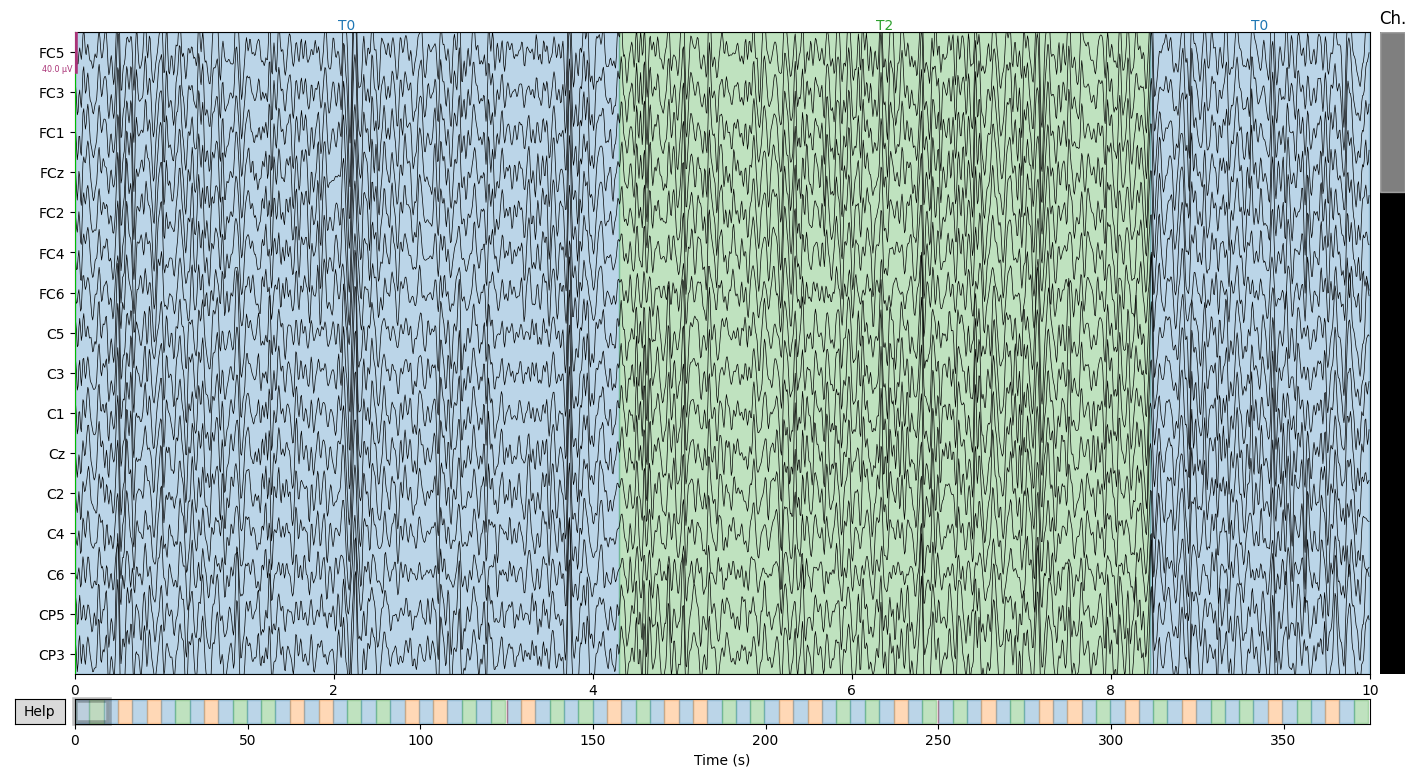

In [9]:
raw.plot(n_channels=16)

Plot sensor positions

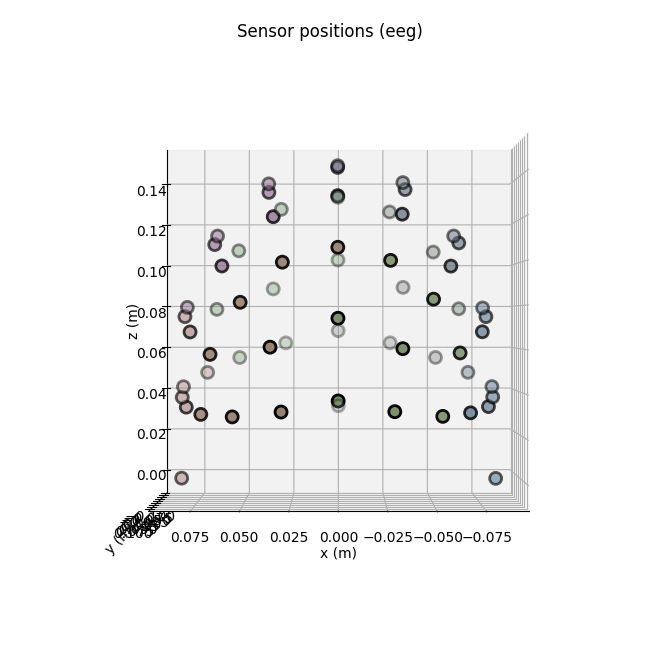

In [10]:
raw.plot_sensors(ch_type='eeg')
raw.plot_sensors(kind='3d', ch_type='eeg', ch_groups='position')

Plot the power spectra over the raw data

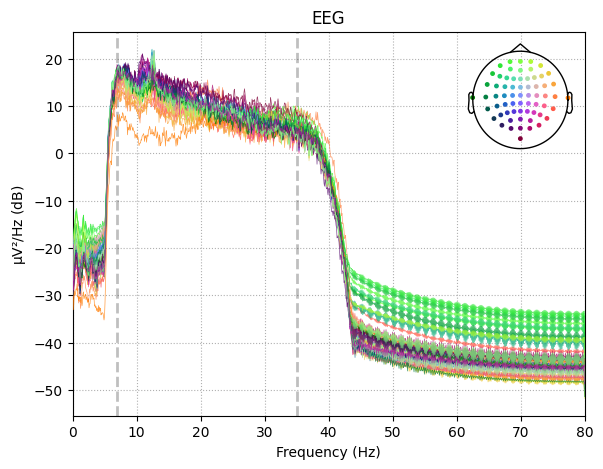

In [11]:
raw.plot_psd()

Plot channel-wise frequency spectra as topography

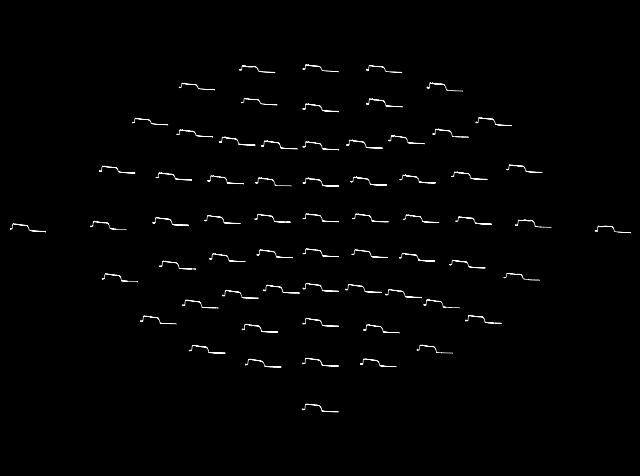

In [12]:
raw.plot_psd_topo()

### Channel Selection

For most BCI applications, we usually don't need **all** channels.

In what follows, we will use only odd-numbered EEG channels (as defined in the EEGBCI dataset documentation).

In [13]:
from mne import pick_types

# Select EEG channels
picks = pick_types(raw.info,
                   meg=False,
                   eeg=True,
                   stim=False,
                   eog=False,
                   exclude='bads')

# Subsample electrodes (odd-numbered channels only)
picks = picks[::2]

### Epoching

[`Epochs`](https://mne.tools/dev/generated/mne.Epochs.html) objects are a way of representing continuous data as a *collection of time-locked trials*.

These are stored in an array of shape (`events x channels x samples`). 

They are useful for many statistical methods in neuroscience, and make it easy to get a sense of what's happening during a trial.

In [14]:
from mne import Epochs, events_from_annotations

# Avoid classification of evoked responses by using epochs that start 1s after cue onset
tmin, tmax = 1., 2.
event_id=dict(hands=2, feet=3)

# Get events from an Annotations object.
events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))
print('Found {} events'.format(events.shape[0]))

# Read epochs
epochs = Epochs(raw,
                events,
                event_id,
                tmin,
                tmax,
                proj=True,
                picks=picks,
                baseline=None,
                preload=True)

# Inspect epochs
print(epochs.info)
print('events x channels x samples:', epochs._data.shape)

# Get labels
labels = epochs.events[:, -1] - 2

Found 45 events
<Info | 8 non-empty values
 bads: []
 ch_names: FC5, FC1, FC2, FC6, C3, Cz, C4, CP5, CP1, CP2, CP6, Fpz, AF7, ...
 chs: 32 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 7.0 Hz
 lowpass: 35.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 32
 projs: []
 sfreq: 160.0 Hz
>
events x channels x samples: (45, 32, 161)


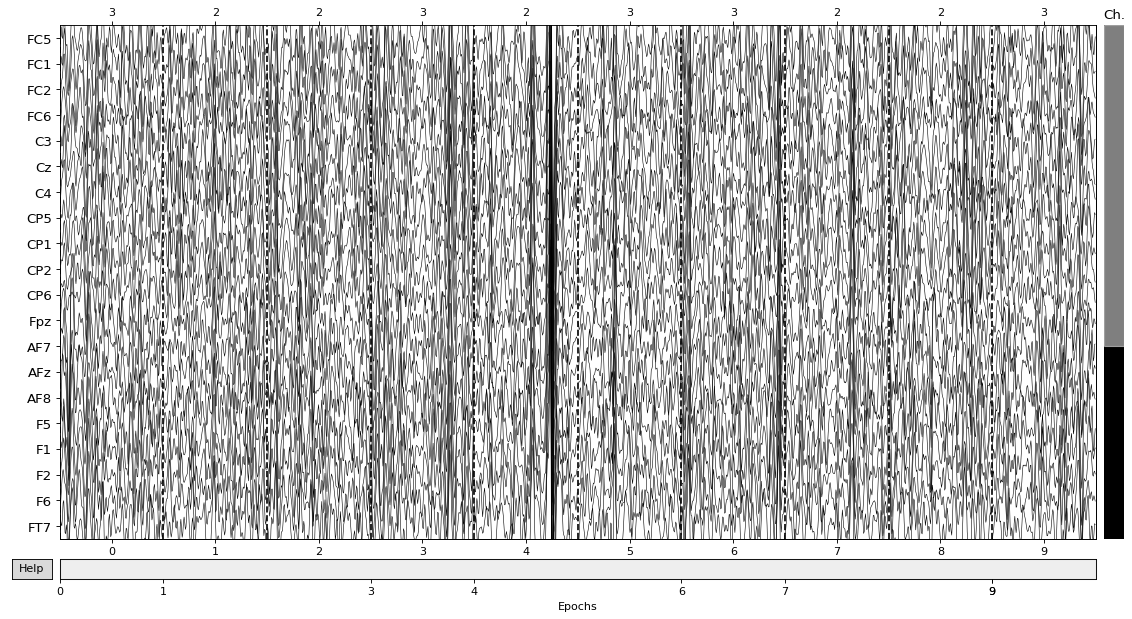

In [15]:
epochs[0:10].plot()

### Classification

#### Preparation

Setup [K-fold Cross Validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

For more information, please check the [Cross-validation: evaluating estimator performance](https://scikit-learn.org/stable/modules/cross_validation.html) section from the [scikit-learn](https://scikit-learn.org/stable/index.html) documentation.

In [16]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=10, shuffle=True, random_state=42)

Retrieve epoch data

In [17]:
epochs_data = 1e6 * epochs.get_data()

#### Linear Discriminant Analysis

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

from mne.decoding import CSP

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, epochs_data, labels, cv=cv, n_jobs=1)

Print the results

In [19]:
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("CSP + LDA Classification accuracy: %f / Chance level: %f" 
                                  % (np.mean(scores), class_balance))

CSP + LDA Classification accuracy: 0.930000 / Chance level: 0.533333


Fit epochs data

In [20]:
%%capture
csp.fit_transform(epochs_data, labels)

Plot CSP patterns estimated on full data for visualization

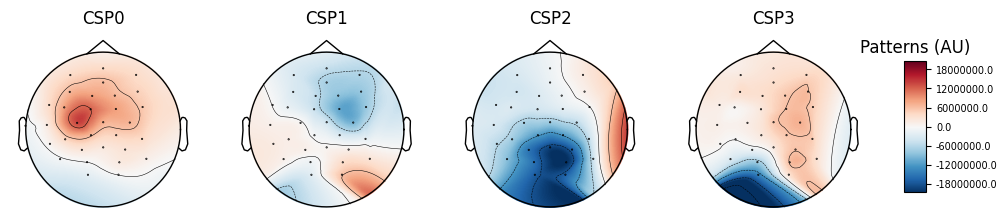

In [21]:
csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)

#### Riemannian Classification

In this section, we will use the [PyRiemann](https://github.com/alexandrebarachant/pyRiemann) module to introduce the basics of [Riemannian Classification](https://hal.archives-ouvertes.fr/hal-00526071/document).

Install the PyRiemann module by issuing the following command:

In [22]:
!pip install pyriemann

First, we need to compute the covariance matrices

In [23]:
from pyriemann.estimation import Covariances

# Compute covariance matrices
cov_data = Covariances().transform(epochs_data)

Classification with [Minimum Distance to Mean](https://pyriemann.readthedocs.io/en/latest/generated/pyriemann.classification.MDM.html) (MDM) classifier

In [24]:
from pyriemann.classification import MDM

# Initialize the MDM classifier
mdm = MDM(metric=dict(mean='riemann', distance='riemann'))

# Use scikit-learn Pipeline with cross_val_score function
scores = cross_val_score(mdm, cov_data, labels, cv=cv, n_jobs=1)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("MDM Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))

MDM Classification accuracy: 0.885000 / Chance level: 0.533333


Display MDM centroid

In [25]:
# Intialize model
mdm = MDM()
mdm.fit(cov_data, labels)

# Initialize figure
fig, axes = plt.subplots(1, 2, figsize=[8, 4])
ch_names = epochs.ch_names

# Hands centroid
df = pd.DataFrame(data=mdm.covmeans_[0], index=ch_names, columns=ch_names)
g = sns.heatmap(df, ax=axes[0], square=True, cbar=False, xticklabels=2, yticklabels=2)
g.set_title('Mean covariance - hands')

# Feet centroid
df = pd.DataFrame(data=mdm.covmeans_[1], index=ch_names, columns=ch_names)
g = sns.heatmap(df, ax=axes[1], square=True, cbar=False, xticklabels=2, yticklabels=2)
plt.xticks(rotation='vertical')
plt.yticks(rotation='horizontal')
g.set_title('Mean covariance - feets')

# Dirty fix
plt.sca(axes[0])
plt.xticks(rotation='vertical')
plt.yticks(rotation='horizontal')
plt.show()

Classification with [Tangent Space Logistic Regression](https://pyriemann.readthedocs.io/en/latest/generated/pyriemann.classification.TSclassifier.html) (TS-LR)

In [26]:
from pyriemann.classification import TSclassifier

# Initialize the TS classifier
tsc = TSclassifier()

# Use scikit-learn Pipeline with cross_val_score function
scores = cross_val_score(tsc, cov_data, labels, cv=cv, n_jobs=1)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Tangent space Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))

Tangent space Classification accuracy: 0.950000 / Chance level: 0.533333


## References

### Books

* Bear, M. F., Connors, B. W., & Paradiso, M. A. (2016). **Neuroscience: Exploring the brain** (4th edition). Wolters Kluwer. 
* Cohen, M. X. (2014). **Analyzing neural time series data: Theory and practice**. The MIT Press.
* Graimann, B., Allison, B., & Pfurtscheller, G. (Eds.). (2010). **Brain-computer interfaces: Revolutionizing human-computer interaction**. Springer.
* Nam, C. S., Nijholt, A., & Lotte, F. (Eds.). (2018). **Brain-computer interfaces handbook: Technological and theoretical advances**. Taylor & Francis, CRC Press.
* Niedermeyer, E., Schomer, D. L., & Lopes da Silva, F. H. (Eds.). (2011). **Niedermeyer’s electroencephalography: Basic principles, clinical applications, and related fields** (6th edition). Wolters Kluwer, Lippincott Williams & Wilkins.

### Packages

* [MNE](https://mne.tools/stable/index.html) - *Open-source Python software for exploring, visualizing, and analyzing human neurophysiological data: MEG, EEG, sEEG, ECoG, and more*
* [SciKit-Learn](https://scikit-learn.org/stable/index.html) - *Machine Learning in Python*
* [Numpy](https://numpy.org) - *Fundamental package for scientific computing with Python*
* [PyRiemann](https://github.com/alexandrebarachant/pyRiemann) - *a python package for covariance matrices manipulation and classification through riemannian geometry*

### Sites

* [BNCI Horizon 2020](http://bnci-horizon-2020.eu) - *The Future of Brain/Neural Computer Interaction: Horizon 2020*
* [EDFbrowser](https://www.teuniz.net/edfbrowser/) - *Free, opensource, multiplatform, universal viewer and toolbox intended for, but not limited to, timeseries storage files like EEG, EMG, ECG, BioImpedance, etc.*

### Blogs

* [Alexandre Barachant's personal blog](http://alexandre.barachant.org/blog/)
* [Brain-Computer Interfaces over EEG](https://bciovereeg.blogspot.com)